<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 3: Topic Modeling <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

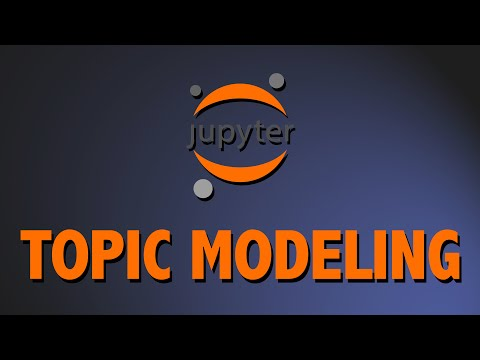

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('ka8k32dszuY', width=640, height=360)

In [1]:
!pwd

Run the following cell to add progress bars to all of the longer running operations in this notebook (thanks to [@akash329d](https://github.com/akash329d)). You might need to install `rich` first (uncomment the first line).

In [2]:
#!pip install rich
%run ../../Lib/progress.py
import warnings
# Ignore pyLDAvis warnings so progress bar works.
warnings.filterwarnings("ignore")

# Topic modeling

This notebook introduces topic modeling. Topic modeling is a type of statistical modeling for the discovery of abstract "topics" that occur in a collection of documents. It is frequently used in NLP to aid the discovery of hidden semantic structures in a collection of texts.

Before you start, please read [this post](https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-5-topic-modeling-a5b0d119add) for an explainer of how topic modeling (and LDA, which is just one form of topic modeling) works.

We'll use the `Gensim` package to create our topic models, which also allows us to run tests to optimize our topic amount.

After reading this notebook, you'll be able to:

1. Use gensim to create topic models;
2. Explore the topic models using `PyLDAvis`;
3. Evaluate and improve topic models using several methods;
4. Give names to topics, and use them to classify text.


## Loading the data

In [3]:
import os
os.getcwd()

'/Users/tomvannuenen/Documents/GitHub/DIGHUM160/Notebooks/Week3'

In [4]:
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

In [5]:
import pandas as pd

df = pd.read_csv('aita_sub_top_sm_lemmas.csv')

In [6]:
df.head(3)

,idint,idstr,created,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class
0,427576402,t3_72kg2a,1506433689,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,679.0,NaN,4917.0,434.0,no a--holes here,NaN
1,551887974,t3_94kvhi,1533404095,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,832.0,NaN,2076.0,357.0,asshole,ass
2,552654542,t3_951az2,1533562299,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,23.0,NaN,1741.0,335.0,Shitpost,NaN


Let's split up the lemmas--we need them tokenized to use in out topic model. All we need to do is run `.split()` on our "lemmas" column to tokenize the data again.

In [7]:
lemmas_split = [lemma.split() for lemma in ProgressDisplay(df['lemmas'])]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 16310/16310 0:00:00

In [8]:
lemmas_split[0][:10]

['girlfriend',
 'recently',
 'beach',
 'friend',
 'tiny',
 'bikini',
 'basically',
 'thong',
 'hate',
 'wear']

## Creating a `Dictionary` with Gensim

Now, let's create our gensim dictionary - a mapping of each word to a unique id – a Document-Term matrix – much like the `CountVectorizer` we saw last week. We'll use gensim's `Dictionary` class for this.

In [11]:
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

# Create Dictionary 
dictionary = corpora.Dictionary(ProgressDisplay(lemmas_split, msg="Create Dictionary"))

# filter extremes and assign new ids
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify() 

# SAVE DICT
dictionary.save('aita_lda.dict')

# Create Document-Term Matrix of our whole corpus 
corpus = [dictionary.doc2bow(text) for text in ProgressDisplay(lemmas_split, msg="Create Dictionary-Term Matrix")]


Create Dictionary-Term Matrix ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 16310/16310 0:00:00

Topic modeling uses a simplifying assumption known as the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.

Let's view some of the corpus we have now:

In [12]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 5),
 (7, 1),
 (8, 1),
 (9, 1)]

Observe the first 10 tuples above. Each consists of words with a unique id. This a mapping of (word_id, word_frequency). For example, (0, 1) above demonstrates that word id 0 occurs once in the first document. Word id 5 occurs 4 times, and so on. This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [13]:
dictionary[0]

'add'

And if you want to see the associated id for some word:

In [14]:
dictionary.token2id['attendance']

8

## Running a model

Let's run our first Gensim LDA topic model! Check out the comments to learn about the function arguments we're using.

Note that topic modeling essentially adds a third latent layer on top of the documents and tokens (which is the representation we saw last week when running SKLearn's `CountVectorizer()`. That third layer consists of topics. Topic modeling assumes that documents are made of topics, and topics is made up of tokens. It also assumes a Dirichlet probability distribution, which encourages docs to only consist of a handful of topics and topics only of a handful of words.

In [18]:
from gensim.models.ldamodel import LdaModel

%time
lda_model = LdaModel(corpus=ProgressDisplay(corpus, iter_count=2),   # stream of document vectors or sparse matrix of shape
            id2word=dictionary,       # mapping from word IDs to words (for determining vocab size)
            num_topics=10,            # amount of topics
            random_state=100,         # seed to generate random state; useful for reproducibility
            passes=2,                 # amount of iterations/epochs 
            per_word_topics=False)    # computing most-likely topics for each word 

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 32620/32620 0:00:17

The most challenging part about topic modeling is creating a *good*, i.e. interpretable, topic model. This is a heavily iterative process. The first thing we should do is visualize the model.

## 1. Visualizing the Topic Model

One of the best ways to visualize a topic model is through the pyLDAvis package. pyLDAv was designed to help users interpret the topics in a topic model. Let's start by downloading the package.

In [19]:
try:
    import pyLDAvis
except ImportError:
    !pip install pyLDAvis

PyLDAvis allows us to visualize our topics. A "good" topic model produces non-overlapping, fairly large bubbles, which should be scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.056078  0.052576       1        1  13.531840
3      0.118204  0.000252       2        1  13.359438
9     -0.028718  0.055901       3        1  12.807278
2      0.069626 -0.047105       4        1  12.326405
8     -0.087643 -0.055458       5        1  10.815561
6      0.050899 -0.115018       6        1   9.487970
0      0.126307  0.043200       7        1   8.812597
7     -0.093568 -0.090108       8        1   6.989827
4     -0.149984  0.016382       9        1   6.825854
1     -0.061200  0.139379      10        1   5.043231, topic_info=        Term          Freq         Total Category  logprob  loglift
79       mom  12283.000000  12283.000000  Default  30.0000  30.0000
169      dad   8500.000000   8500.000000  Default  29.0000  29.0000
1385  sister  11658.000000  11658.000000  Default  28.0000  28.0000
303      eat   5169.000000   5169.000000  Default  27.0000  27.0000
186      kid  15167.000000  15167.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
2137      bf    328.759808   2108.540848  Topic10  -5.7186   1.1287
99     point    350.995623   4991.289291  Topic10  -5.6532   0.3324
218      use    369.944241   8072.224949  Topic10  -5.6006  -0.0957
86       old    362.146789   7587.591181  Topic10  -5.6219  -0.0551
101     post    329.764832   3542.052061  Topic10  -5.7156   0.6130

[847 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1481      1  0.000323    $
1481      2  0.000323    $
1481      3  0.050394    $
1481      4  0.879960    $
1481      5  0.001292    $
...     ...       ...  ...
2355      3  0.055073    £
2355      4  0.914217    £
2355      7  0.003672    £
2355      9  0.011015    £
2355     10  0.014686    £

[3292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 10, 3, 9, 7, 1, 8, 5, 2])

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/

On the left, there is a 2D plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map). This plot uses a multidimensional scaling (MDS) algorithm. 
- Similar topics should appear close together on the plot; dissimilar topics should appear far apart. 
- The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

### Exploring topics and words
- You can scrutinize a topic more closely by clicking on its circle, or entering its number in the "selected topic" box in the upper-left (Note that, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics.)
- If you roll your mouse over a term in the bar chart on the right, the topic circles will resize in the plot on the left. This shows the strength of the relationship between the topics and the selected term.

### Salience
On the right, there is a bar chart with the top terms. When no topic is selected in the plot on the left, the bar chart shows the top-30 most **salient** terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

### Probability Vs Exclusivity 
When you select a particular topic, this bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart:

* Setting λ close to 1.0 (the default) will rank the terms according to their probability within the topic.
* Setting λ close to 0.0 will rank the terms according to their "distinctiveness" or "exclusivity" within the topic. This means that terms that occur only in this topic, and do not occur in other topics.

You can move the slider between 0.0 and 1.0 to weigh term probability and exclusivity.

### Exploring the graph
The interactive visualization pyLDAvis produces is helpful for **individual** topics: you can manually select each topic to view its top most frequent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a name or "meaning" to each topic. 

It also helps you to see the **relationships** between topics: exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

### Getting insights about the model
As you can see, this model probably has too many topics: they are overlapping, and most of them appear in one corner of the graph. So we have our first hint that we might want to alter our model.

## 2. Calculating Topic Coherence

We can apply statistical measures to help us determine the optimal number of topics in our topic model.

**Topic Coherence** measures the score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. This helps to distinguish between topics that are semantically interpretable topics, and topics that are artifacts of statistical inference. 

A set of statements or facts is said to be coherent if the statements support each other. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

A good model will generate topics with *high* topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.

*(There are different ways to measure coherence. For instance, the c_v measure used here retrieves cooccurrence counts for the given words using a sliding window, with a window size 110. The counts are used to calculate the NPMI (a measure of association) of every top word to every other top word. This results in a set of vectors, one for every top word. The one-set segmentation of the top words leads to the calculation of the similarity between every top word vector and the sum of all top word vectors. As similarity measure the cosinus is used. The coherence is the arithmetic mean of these similarities.)*

In [16]:
#import logging
#logging.getLogger().setLevel(logging.CRITICAL)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=ProgressDisplay(lemmas_split), dictionary=dictionary, coherence='c_v') 
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.40183156444316365


There's no hard or fast rule on what makes a good coherence score.
In general, a coherence score of .4 means you probably are not using the right number of topics. .6 to .7 is good. Anything more is suspiciously great. As you can see, our coherence score here is very low, so we should definitely try to improve upon our model.

## 3. Tweaking the data

Remember we used the lemmas of our dataset? What if we tweaked it some more -- for instance, by POS tagging?

POS - Part of Speech - tagging is the process of marking up a word in a corpus to a corresponding part of a speech tag (noun, adjective, verb, etc.). Often it is a process of converting a sentence to a list of tuples where each tuple takes the form of (word, tag).

Let's do this with spaCy.

In [17]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import spacy
#!spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

def POS(text, allowed_postags = ['NOUN', 'ADJ']):
    parsed = nlp(text)
    return [token.lemma_ for token in parsed if token.pos_ in allowed_postags]

In [21]:
# This will take a long time
pos_lemmas_split = [POS(text) for text in ProgressDisplay(df['lemmas'])]

We can save our POS-tagged lemmas to disk again. Let's save them to a JSON file, a common data file type. See https://www.w3schools.com/js/js_json_intro.asp for more. Let's also update our CSV so we have our POS tagged lemmas in there as well.

In [29]:
import json
with open('aita_pos_lemmas.json', 'w' ) as write:
    json.dump(pos_lemmas_split, write)

# Uncomment the following two lines if you want to import this data again
#with open("aita_pos_lemmas.json") as f:
#    pos_lemmas = json.load(f)


In [ ]:
# turn them into a string so we can save them in our DF
str_pos_lemmas = [' '.join(t) for t in pos_lemmas_split]

In [ ]:
str_pos_lemmas[0]

In [ ]:
df.insert(loc=9, column='pos_lemmas', value=str_pos_lemmas)

In [ ]:
df.to_csv('aita_sub_top_sm_pos_lemmas.csv', index=False)

In [ ]:
# Let's see the difference between our lemmas and our POS-tagged lemmas
df[['lemmas','pos_lemmas']]

Next, we need to create new dictionary and corpus objects for Gensim.

In [ ]:
# Create Dictionary 
pos_dictionary = corpora.Dictionary(ProgressDisplay(pos_lemmas_split, msg="Create Dictionary"))

# filter extremes and assign new ids
pos_dictionary.filter_extremes(no_below=10, no_above=0.4)
pos_dictionary.compactify() 

# SAVE DICT
pos_dictionary.save('aita_pos_lda.dict')

# Create Document-Term Matrix of our whole corpus 
pos_corpus = [pos_dictionary.doc2bow(text) for text in ProgressDisplay(pos_lemmas_split, msg="Create Dictionary-Term Matrix")]


## 3. Tweaking hyperparameters

Next, let's change some hyperparameters. This can also determine how interpretable our topic models become.

`passes` controls how often we train the model on the entire corpus. Another word for passes might be “epochs”.
 
`iterations` is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

Gensim's designer suggests the following way to choose iterations and passes. First, enable `logging`, and set `eval_every = 1` in `LdaModel`. This will yield a **perplexity** score for every update. Perplexity is a measure of how well a probability model predicts a sample. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. 


In [35]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='gensim.log', filemode='w', format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO)

lda_model_tweak = LdaModel(corpus=ProgressDisplay(pos_corpus, iter_count=20),
                           id2word=pos_dictionary,
                           num_topics=20, 
                           random_state=100,
                           eval_every=1,           # show perplexity after every update for visualization
                           iterations=50,          # number of model iterations over each doc
                           passes=20,              # number of model training cycles, aka epochs
                           per_word_topics=False)

Using regular expressions we can now search through our newly created "gensim.log" file and find  / plot the relevant information.
This shows how topic/word assignments reach a steady state and no longer change much, (i.e. converge). Adding "passes" when running the topic model can increase the log-likelihood. The higher the value of the log-likelihood, the better our model fits the dataset.

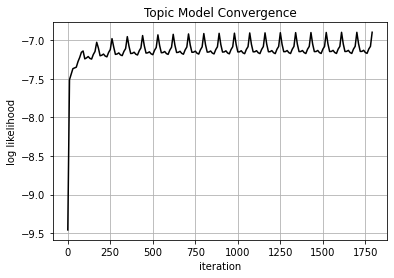

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import re

p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
likelihood = [float(t[0]) for t in tuples]
perplexity = [float(t[1]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,likelihood,c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.savefig("convergence_liklihood_1_it_1_pa.pdf")

 Note that the graph contains about 20 "peaks", which refers to the number of `passes` we set above. As you can see, the model converges quite rapidly, so we do not need to set `passes` very high.

## 4. Changing number of topics

The final and most important thing we can do to find optimal scores is to play around with the amount of topics our model creates. One way to do this is to build many LDA models with different values of number of topics (k), and then pick the one that gives the highest coherence value. Choosing a ‘k’ at the end of a rapid growth of topic coherence usually yields meaningful and interpretable topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

This `compute_coherence_values()` function trains multiple LDA models, provides the models, and tells you their corresponding coherence scores.

Also note the docstring I create here: these are documentation for the functions we create. It describes what a function does, and can be called using `help(function_X)`.

In [37]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Tokenized text (list of lis of str)
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = int(limit/step - start/step)
    current_amount = 0
    passes=10
    corpus = ProgressDisplay(corpus, iter_count=passes*total_amount)
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, iterations=50, passes=passes, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values


In [38]:
help(compute_coherence_values)

Help on function compute_coherence_values in module __main__:

compute_coherence_values(dictionary, corpus, texts, start, limit, step)
    Compute c_v coherence for various number of topics
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Tokenized text (list of lis of str)
    limit : Max num of topics
    
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics



Using our new function, let's run a bunch of topic models with different amounts of topics.

In [39]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=pos_dictionary, 
                                                        corpus=pos_corpus, texts=pos_lemmas_split, 
                                                        start=6, limit=30, step=2)

Built 1 of 12 models
Built 2 of 12 models
Built 3 of 12 models
Built 4 of 12 models
Built 5 of 12 models
Built 6 of 12 models
Built 7 of 12 models
Built 8 of 12 models
Built 9 of 12 models
Built 10 of 12 models
Built 11 of 12 models
Built 12 of 12 models


Now, from all those models, let's visualize the output of the coherence scores.

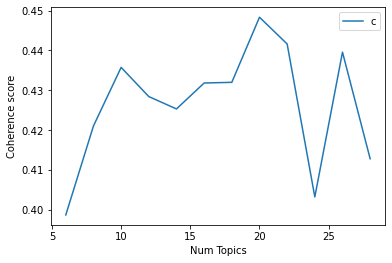

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show graph
start=6; limit=30; step=2
x = range(start, limit, step) # range uses start, stop, and incrementation
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# Print these coherence scores
c = 0
for m, cv in zip(x, coherence_values):
    print(f"model_list[{c}]: Num Topics = {m}, Coherence Value = {round(cv, 4)}")
    c += 1

model_list[0]: Num Topics = 6, Coherence Value = 0.3987
model_list[1]: Num Topics = 8, Coherence Value = 0.421
model_list[2]: Num Topics = 10, Coherence Value = 0.4357
model_list[3]: Num Topics = 12, Coherence Value = 0.4284
model_list[4]: Num Topics = 14, Coherence Value = 0.4253
model_list[5]: Num Topics = 16, Coherence Value = 0.4318
model_list[6]: Num Topics = 18, Coherence Value = 0.432
model_list[7]: Num Topics = 20, Coherence Value = 0.4483
model_list[8]: Num Topics = 22, Coherence Value = 0.4416
model_list[9]: Num Topics = 24, Coherence Value = 0.4032
model_list[10]: Num Topics = 26, Coherence Value = 0.4396
model_list[11]: Num Topics = 28, Coherence Value = 0.4128


If the coherence score seems to keep increasing, it generally makes sense to pick the model that gave the highest CV before dropping again. Following this "elbow method", we have a few options.

However, such methods are only heuristics. The scores we have here are not that far apart. At this point you should *go back* to pyLDAvis using the models from our `model_list`, and compare them to see which topic model looks better. Based on these combined insights, I will pick the 5th model, with 16 topics.

In [42]:
from gensim import corpora, models, similarities

# SAVE MODEL
optimal_lda_model = model_list[5]
optimal_lda_model.save('aita_pos_lda_optimal.model')


In [43]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_lda_model, pos_corpus, pos_dictionary)
lda_viz

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.009904 -0.066799       1        1  19.240640
6      0.172488  0.032844       2        1  10.191730
8     -0.009917 -0.028770       3        1   9.329693
13    -0.087884  0.132429       4        1   7.352649
11    -0.022299  0.140750       5        1   6.720075
10     0.185417  0.074224       6        1   6.491933
4      0.120132 -0.053379       7        1   5.835890
5      0.171571 -0.025763       8        1   5.695920
1     -0.159991  0.099255       9        1   5.278807
3      0.152859  0.026013      10        1   4.332233
2     -0.004799 -0.213537      11        1   4.244993
14     0.055341 -0.086146      12        1   3.916134
9     -0.166936 -0.003075      13        1   3.814625
0     -0.188820  0.126893      14        1   2.916226
7     -0.021875  0.095442      15        1   2.549234
12    -0.185382 -0.250381      16        1   2.089219, topic_info=         Term          Freq         Total Category  logprob  loglift
523   husband  10665.000000  10665.000000  Default  30.0000  30.0000
147      wife   9792.000000   9792.000000  Default  29.0000  29.0000
134    parent  11391.000000  11391.000000  Default  28.0000  28.0000
894    sister   7766.000000   7766.000000  Default  27.0000  27.0000
259     money   7612.000000   7612.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
130      nice    234.736021   2247.811237  Topic16  -4.6770   1.6091
33       girl    267.564685   3958.019367  Topic16  -4.5461   1.1742
507     small    195.476792   2452.457535  Topic16  -4.8601   1.3390
50       look    183.709607   1995.659402  Topic16  -4.9221   1.4830
474  business    171.192273   1329.315608  Topic16  -4.9927   1.8187

[1115 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4870      2  0.911786    14f
4870     11  0.082890    14f
2136     11  0.990093    30f
3147     12  0.969005    35k
4833      5  0.961063    7th
...     ...       ...    ...
149      10  0.000379  young
149      12  0.013660  young
149      16  0.023526  young
4121      8  0.985847  youth
1569      6  0.977604      £

[3299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 7, 9, 14, 12, 11, 5, 6, 2, 4, 3, 15, 10, 1, 8, 13])

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/

In case you want to load these models from disk again:

In [22]:
# LOAD MODEL
optimal_lda_model = LdaModel.load('aita_pos_lda_optimal.model')

# LOAD DICT
pos_dictionary = corpora.Dictionary.load('aita_pos_lda.dict')

# LOAD CORPUS
pos_corpus = [pos_dictionary.doc2bow(text) for text in ProgressDisplay(pos_lemmas_split)]

## Naming our topics

The next thing we should do is name our topics. This is the most important interpretative step in the process: after all, our model has no semantic knowledge of the data. We will print out the top words of each topic, then go over all of them and give them names.

In [23]:
from pprint import pprint

# Select the ideal model and print the topics
model_topics = optimal_lda_model.show_topics(formatted=False)
pprint(optimal_lda_model.print_topics(num_words=20))

[(0,
  '0.096*"car" + 0.087*"dog" + 0.033*"cat" + 0.026*"drive" + 0.015*"neighbor" '
  '+ 0.013*"home" + 0.012*"property" + 0.011*"walk" + 0.011*"door" + '
  '0.010*"animal" + 0.010*"house" + 0.010*"yard" + 0.009*"window" + '
  '0.009*"parking" + 0.008*"police" + 0.008*"accident" + 0.008*"key" + '
  '0.008*"spot" + 0.008*"vet" + 0.008*"neighborhood"'),
 (1,
  '0.071*"room" + 0.022*"use" + 0.022*"sleep" + 0.020*"bathroom" + 0.018*"bed" '
  '+ 0.018*"apartment" + 0.017*"bedroom" + 0.016*"house" + 0.015*"door" + '
  '0.015*"roommate" + 0.014*"clean" + 0.013*"live" + 0.013*"home" + '
  '0.012*"night" + 0.011*"stuff" + 0.009*"space" + 0.009*"issue" + 0.008*"bag" '
  '+ 0.008*"place" + 0.008*"share"'),
 (2,
  '0.040*"hair" + 0.036*"comment" + 0.023*"people" + 0.022*"post" + '
  '0.016*"picture" + 0.011*"use" + 0.011*"video" + 0.010*"message" + '
  '0.009*"update" + 0.009*"color" + 0.009*"makeup" + 0.009*"black" + '
  '0.009*"edit" + 0.009*"white" + 0.008*"photo" + 0.007*"short" + 0.007*"long

**Important**: If you are using your own data, make sure to replace the following names with those of your own!

In [25]:
# giving names to our topics
topic_names = {0: 'around the house', 
               1: 'home',
               2: 'physical appearance',
               3: 'pregnancy & newborns',
               4: 'marriage & weddings',
               5: 'children',
               6: 'family',
               7: 'school & medicine',
               8: 'work',
               9: 'food',
               10: 'family',
               11: 'money',
               12: 'clothes & shopping',
               13: 'general',
               14: 'lifestyle & psychology',
               15: 'friends & dating'}
               

Naming topics is a heavily iterative process, based on looking closer at particular posts (see below). This process also means renaming topics: for instance, I had originally named topic 0 "pets" based on the top words, but upon looking closer at the posts associated with this topic, I changed it to a more general "around the house" category, where said pets often can be fou.

## Finding most dominant topics per submission

Topic modeling has several practical applications. One of them is to determine what topic a Reddit post is about. To figure this out, we find the topic number that has the highest percentage contribution to that thread. We'll write a `dominant_topic()` function that aggregates this information in a DataFrame.

In [26]:
def dominant_topic(ldamodel=optimal_lda_model, corpus=corpus, texts=df['selftext']):
    # Create DF
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each thread
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                # get value of topic_names dict based on key
                topic_name = topic_names[topic_num]
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), topic_name, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Dominant_Topic_Name', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return topics_df 

# Run function
df_topic_keywords = dominant_topic(ldamodel=optimal_lda_model, corpus=pos_corpus, texts=df['selftext'])

# Format
df_dominant_topic = df_topic_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Dominant_Topic_Name', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Dominant_Topic,Dominant_Topic_Name,Topic_Perc_Contrib,Keywords,Text
0,15.0,friends & dating,0.5187,"friend, talk, people, good, boyfriend, tell, g...",My girlfriend recently went to the beach with ...
1,0.0,around the house,0.3273,"car, dog, cat, drive, neighbor, home, property...",My parents smoke like chimneys. I used to as w...
2,12.0,clothes & shopping,0.4028,"dress, woman, wear, store, man, clothe, female...",Hi guys. Throwaway for obv reasons.\n\nI'm a f...
3,9.0,food,0.5047,"food, dinner, meal, order, cook, restaurant, t...","Yesterday night, me and my GF decided to go ou..."
4,9.0,food,0.3251,"food, dinner, meal, order, cook, restaurant, t...","My wife and I are vegetarians, much to my in-l..."
...,...,...,...,...,...
16305,11.0,money,0.7399,"money, pay, job, month, rent, work, college, h...",My (29m) good friend (26f) is currently house ...
16306,11.0,money,0.2970,"money, pay, job, month, rent, work, college, h...",So I have a Degree in Fashion which some peopl...
16307,5.0,children,0.5170,"kid, child, parent, old, life, family, young, ...",My husband and I have been friends since middl...
16308,5.0,children,0.3039,"kid, child, parent, old, life, family, young, ...",I (30F) and my husband (30M) recently moved in...


We can now find the posts with a dominant topic using `.loc`

In [27]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic_Name'] == 'around the house']

,Dominant_Topic,Dominant_Topic_Name,Topic_Perc_Contrib,Keywords,Text
1,0.0,around the house,0.3273,"car, dog, cat, drive, neighbor, home, property...",My parents smoke like chimneys. I used to as w...
14,0.0,around the house,0.2965,"car, dog, cat, drive, neighbor, home, property...","So as the title says, i was minding my own bus..."
32,0.0,around the house,0.4200,"car, dog, cat, drive, neighbor, home, property...","Within the past year, my girlfriend moved in w..."
67,0.0,around the house,0.3717,"car, dog, cat, drive, neighbor, home, property...",I was walking home from school about two weeks...
71,0.0,around the house,0.5967,"car, dog, cat, drive, neighbor, home, property...",I pay $85 a month for this spot in my apartmen...
...,...,...,...,...,...
16236,0.0,around the house,0.3814,"car, dog, cat, drive, neighbor, home, property...",Background: neighbours have a pedigree cat tha...
16244,0.0,around the house,0.4617,"car, dog, cat, drive, neighbor, home, property...",My wife left to go shopping for about 2 hours ...
16254,0.0,around the house,0.4054,"car, dog, cat, drive, neighbor, home, property...",I(25F) and my girlfriend(24F) recently moved i...
16280,0.0,around the house,0.6071,"car, dog, cat, drive, neighbor, home, property...",My brother’s car got messed up so he asked me ...


## Topic distribution across submissions

We can also inspect the volume and distribution of topics in order to judge how widely each topic is discussed in our posts. The below table exposes that information.

In [292]:
# Number of posts for each topic
topic_counts = df_topic_keywords['Dominant_Topic'].value_counts()

# Percentage of posts for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 2)

# Topic Number and Keywords
topic_num_keywords = df_topic_keywords[['Dominant_Topic', 'Dominant_Topic_Name', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topic_dist = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topic_dist.columns = ['Dominant_Topic', 'Dominant_Topic_Name', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topic_dist[:10]

,Dominant_Topic,Dominant_Topic_Name,Topic_Keywords,Num_Documents,Perc_Documents
0.0,15.0,friends & dating,"friend, talk, people, good, boyfriend, tell, g...",468.0,0.03
1.0,0.0,around the house,"car, dog, cat, drive, neighbor, home, property...",848.0,0.05
2.0,12.0,clothes & shopping,"dress, woman, wear, store, man, clothe, female...",470.0,0.03
3.0,9.0,food,"food, dinner, meal, order, cook, restaurant, t...",538.0,0.03
4.0,9.0,food,"food, dinner, meal, order, cook, restaurant, t...",937.0,0.06
5.0,15.0,friends & dating,"friend, talk, people, good, boyfriend, tell, g...",686.0,0.04
6.0,11.0,money,"money, pay, job, month, rent, work, college, h...",1973.0,0.12
7.0,15.0,friends & dating,"friend, talk, people, good, boyfriend, tell, g...",214.0,0.01
8.0,15.0,friends & dating,"friend, talk, people, good, boyfriend, tell, g...",1390.0,0.09
9.0,8.0,work,"work, people, job, company, new, lot, office, ...",801.0,0.05


As you can see, the "money" topic is the most pervasive dominant topic across our data.

## Text classification with LDA

Beyond data exploration, one of the key uses for an LDA model is providing a compact, quantitative description of natural language text. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a probability distribution across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

First, let's create a little helper function that can retrieve a sample of our original dataframe:

In [30]:
def get_sample(i):
    return df.iloc[i].selftext

In [31]:
sample = get_sample(3)
sample

'Yesterday night, me and my GF decided to go out to eat. She is vegan and I’m not. This was her first day going vegan. When we were asking for our for our food, I asked if I could have a meal that is basically Steak, Asparagus, and Rice, My girlfriend was offended that I would eat meat on her first day vegan. I told her I’m not vegan and I can order whatever I want, but she wouldn’t listen. AITA in this situation?'

To use an LDA model to generate a vector representation of new text, we need our previously preprocessed "pos_lemmas" column.

In [43]:
df = pd.read_csv('aita_sub_top_sm_pos_lemmas.csv').dropna(subset=['pos_lemmas'])
lemmas_s = [doc.split(" ") for doc in df.pos_lemmas]

Let's do the rest of our preprocessing using spaCy. We also need to create a bag-of-words representation using LDA.

Once our LDA model is trained, we can use it to classify any input text as a mixture of topics. 

In [45]:
import spacy
nlp = spacy.load('en_core_web_sm')

def lda_classifier(text, min_topic_freq=0.1, allowed_postags = ['NOUN', 'ADJ']):
    parsed_text = nlp(text)
    unigram_text = [token.lemma_ for token in parsed_text if token.pos_ in allowed_postags
                  and not token.is_punct or token.is_space or token.is_digit]
    text_bow = dictionary.doc2bow(unigram_text)
    text_lda = optimal_lda_model[text_bow]
    text_lda = sorted(text_lda, key=lambda x:x[1], reverse=True)
    for topic_number, freq in text_lda:
        if freq < min_topic_freq:
            break    
        print('{:10} {}'.format(topic_names[topic_number],round(freq, 3)) )


In [46]:
lda_classifier(sample)

friends & dating 0.48100000619888306
general    0.22100000083446503
lifestyle & psychology 0.10999999940395355


Looking a bit closer at posts of particular topics, we can get a better insight into what our topic model "thinks" our posts are about. As you see, our LDA model classified this post fairly well: it's about dating and lifestyle choices. However, not all posts will be classified well. 

Using this information, we could go back to our `topic_names` and rename topics that we now have better insights into. 

### Classifying new text
Finally let's throw in a new text, to see how our topic model classifies it!

In [299]:
new = """I went to dinner with my boyfriend last night. He told me he'd like to have children 
and is looking into buying a house for us. Then he showed me a ring, and wants to get engaged! 
We only known each other for three months so I told him I wasn't sure. AITA?"""

In [300]:
lda_classifier(new)

marriage & weddings 0.28600001335144043
children   0.2029999941587448
home       0.11900000274181366
general    0.11800000071525574
friends & dating 0.10000000149011612


## Adding topics to original DF

Once we are happy with your topic names, we can add the dominant topic names to our original DataFrame and save it.

In [290]:
df['dom_topic'] = df_dominant_topic['Dominant_Topic_Name']
df['dom_topic_num'] = df_dominant_topic['Dominant_Topic']

df.to_csv('aita_sub_top_sm_pos_lemmas_topics.csv', index=False)

In [291]:
df.head(3)

,idint,idstr,created,created_datetime,nsfw,author,title,selftext,lemmas,pos_lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class,dom_topic,dom_topic_num
0,427576402,t3_72kg2a,1506433689,2017-09-26 13:48:09,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,beach friend tiny bikini hate public wear wear...,679.0,NaN,4917.0,434.0,no a--holes here,NaN,friends & dating,15.0
1,551887974,t3_94kvhi,1533404095,2018-08-04 17:34:55,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,parent smoke son week invite parent hour night...,832.0,NaN,2076.0,357.0,asshole,ass,around the house,0.0
2,552654542,t3_951az2,1533562299,2018-08-06 13:31:39,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,obv reason female child area wear thong penis ...,23.0,NaN,1741.0,335.0,Shitpost,NaN,clothes & shopping,12.0


# Reflection: The hermeneutics of topic modeling 

One thought to end with: for most topic models you will create, it will be hard to apply a meaningful interpretation to each topic. Not every topic will have some meaningful insight "fall out of it" upon first inspection. This is a typical issue in machine learning, which can pick up on patterns that might not make sense to humans.

It is an open question to which extent you should let yourself be surprised by particular combinations of words in a topic, or if topic models primarily should follow the intuitions you already have as a researcher. What makes for a "good" topic model probably straddles the boundaries of surprise and expectation.